In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.constants import golden
plt.style.use('default')
plt.rc('figure', figsize=((5.0, 5.0 / golden)))

# VARIABILI
csvfile = 'csv/alldata.csv'
distance_param = 'CDistance'
colori = ['blue', 'red', 'orange', 'limegreen', 'purple']
myindex = [
    '7:00', '8:00', '9:00', '10:00',
    '11:00', '12:00', '13:00', '14:00',
    '15:00','16:00', '17:00', '18:00',
    '19:00', '20:00', '21:00', '22:00',
    '23:00']

# LETTURA DATI
tragitti = pd.read_csv(csvfile, index_col=False)
pre_lock_cond = (tragitti['Month'] == 3) & (tragitti['Day'] <= 12)
post_lock_cond = ((tragitti['Month'] == 5) & (tragitti['Day'] >= 4)) | (tragitti['Month'] > 5)
tragitti = tragitti[post_lock_cond]

def clean(df):
    distance_cond = df[distance_param] > 0
    moovit_cond = df['Public'] > 12
    public_cond = df['Public'] > 0
    bike_cond = df['Bike'] > 0
    foot_cond = df['Foot'] > 0
    car_cond = df['Car'] > 0
    car2go_cond = df['Car2Go'] > 0
    enjoy_cond = df['Enjoy'] > 0
    coherence_cond = (df['Car'] <= df['Car2Go']) & (df['Car'] <= df['Enjoy'])
    cleaned = distance_cond & public_cond & bike_cond & foot_cond & car_cond & car2go_cond & enjoy_cond & coherence_cond
    return cleaned

In [2]:
replace = {}
replace['Car'] = 'Auto'
replace['Public'] = 'ATM'
replace['Bike'] = 'Bici'
replace['Foot'] = 'A piedi'
replace['Enjoy'] = 'Enjoy'

# Velocita' media durante il giorno
def vmedia_giorno(df, mezzo):
    ore = range(7, 24)
    vmedia_giorno_ore = []
    for ora in ore:
        tragitti_fascia_oraria = df[df['Hour'] == ora]
        velocita_media_oraria = (tragitti_fascia_oraria[distance_param] * 60.) / tragitti_fascia_oraria[mezzo]
        vmedia_giorno_ore.append(velocita_media_oraria.mean())
    return vmedia_giorno_ore
    
def vmedia_week(df, mezzo):    
    lst = [vmedia_giorno(df, mezzo)]
    array = np.array(lst).T
    
    return pd.DataFrame(array, index=myindex, columns=[replace[mezzo]]).round(2)

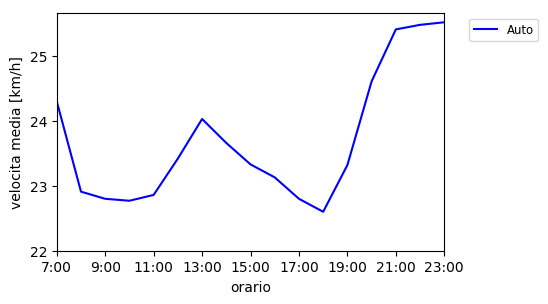

In [3]:
tragitti = tragitti[clean(tragitti)]

vmedia_week(tragitti, 'Car').plot(color=colori[0])
plt.yticks(range(22, 26))
plt.xlabel('orario')
plt.ylabel('velocita media [km/h]')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.show()

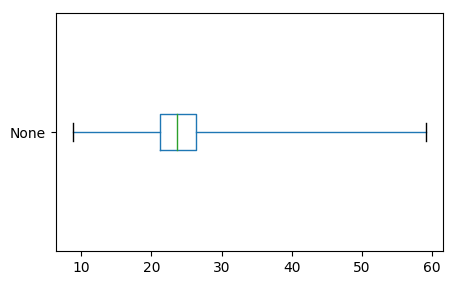

In [4]:
df = (tragitti[distance_param] * 60.) / tragitti['Car']
df.plot.box(vert=False, whis='range')
plt.show()

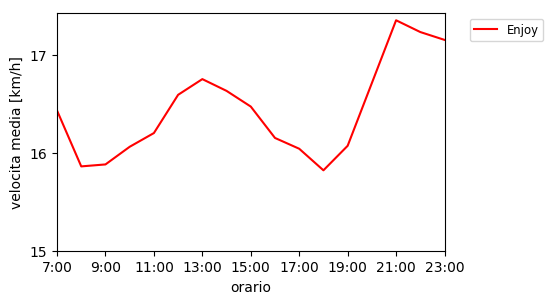

In [5]:
vmedia_week(tragitti, 'Enjoy').plot(color=colori[1])
plt.yticks(range(15, 18))
plt.xlabel('orario')
plt.ylabel('velocita media [km/h]')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.show()

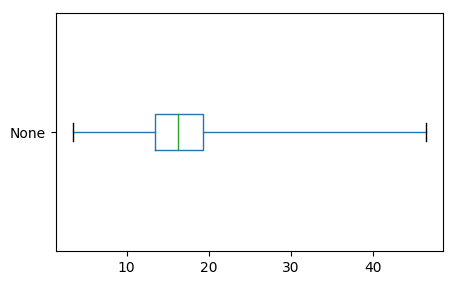

In [6]:
df = (tragitti[distance_param] * 60.) / tragitti['Enjoy']
df.plot.box(vert=False, whis='range')
plt.show()

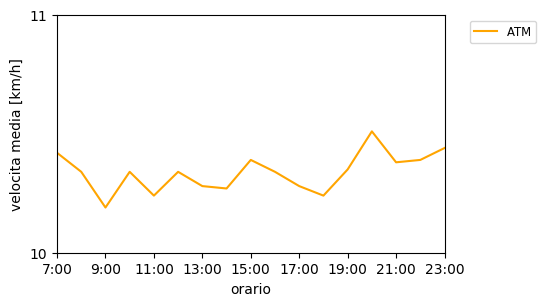

In [7]:
vmedia_week(tragitti, 'Public').plot(color=colori[2])
plt.yticks(range(10, 12))
plt.xlabel('orario')
plt.ylabel('velocita media [km/h]')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.show()

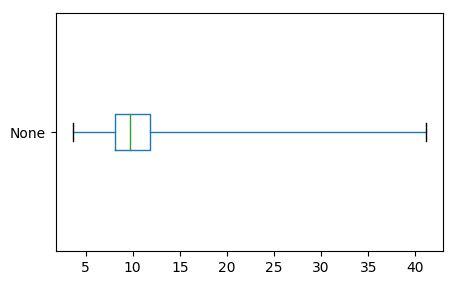

In [8]:
df = (tragitti[distance_param] * 60.) / tragitti['Public']
df.plot.box(vert=False, whis='range')
plt.show()

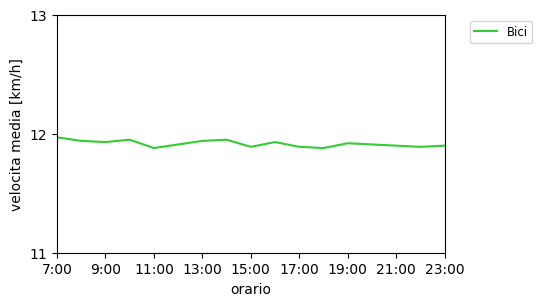

In [9]:
distance_param = 'FDistance'
vmedia_week(tragitti, 'Bike').plot(color=colori[3])
plt.yticks(range(11, 14))
plt.xlabel('orario')
plt.ylabel('velocita media [km/h]')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.show()

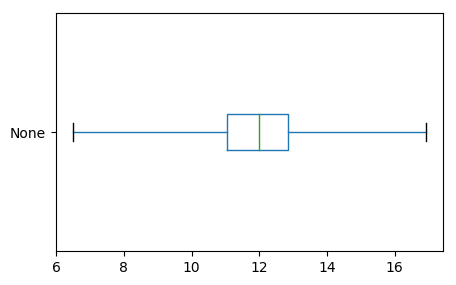

In [10]:
df = (tragitti[distance_param] * 60.) / tragitti['Bike']
df.plot.box(vert=False, whis='range')
plt.show()

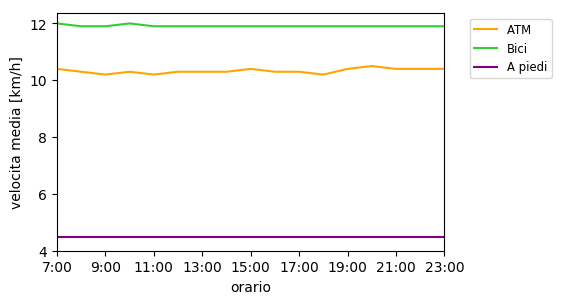

In [11]:
distance_param = 'CDistance'
lst = [vmedia_giorno(tragitti, 'Public')]

distance_param = 'FDistance'
lst.append(vmedia_giorno(tragitti, 'Bike'))
lst.append(vmedia_giorno(tragitti, 'Foot'))

array = np.array(lst).T

x = pd.DataFrame(array, index=myindex, columns=['ATM', 'Bici', 'A piedi']).round(1)
x.plot(color=['orange', 'limegreen', 'purple'])
plt.yticks(range(4, 14, 2))
plt.xlabel('orario')
plt.ylabel('velocita media [km/h]')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.show()

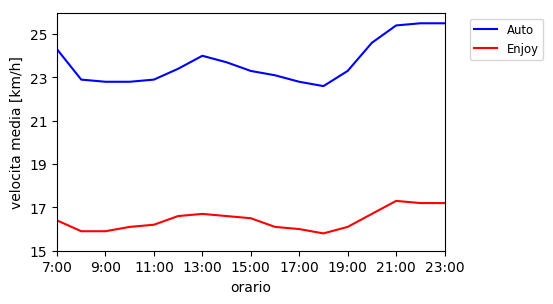

In [12]:
distance_param = 'CDistance'
lst = [vmedia_giorno(tragitti, 'Car'),
      vmedia_giorno(tragitti, 'Enjoy')]

array = np.array(lst).T

x = pd.DataFrame(array, index=myindex, columns=['Auto', 'Enjoy']).round(1)
x.plot(color=colori)
plt.yticks(range(15, 27, 2))
plt.xlabel('orario')
plt.ylabel('velocita media [km/h]')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.show()

In [13]:
velocita_media = (tragitti[distance_param] * 60.) / tragitti['Car']
velocita_media.describe()

count    49560.000000
mean        23.838455
std          3.970546
min          8.912400
25%         21.171049
50%         23.715333
75%         26.321036
max         59.076545
dtype: float64

In [14]:
velocita_media.median()

23.715333333333334

In [15]:
velocita_media = (tragitti[distance_param] * 60.) / tragitti['Enjoy']
velocita_media.describe()

count    49560.000000
mean        16.477040
std          4.264505
min          3.532163
25%         13.455500
50%         16.287250
75%         19.285104
max         46.417286
dtype: float64

In [16]:
velocita_media.median()

16.28725

In [17]:
velocita_media = (tragitti[distance_param] * 60.) / tragitti['Public']
velocita_media.describe()

count    49560.000000
mean        10.278539
std          2.985263
min          3.714837
25%          8.149819
50%          9.754315
75%         11.821679
max         41.096000
dtype: float64

In [18]:
velocita_media.median()

9.75431527093596

In [19]:
velocita_media = (tragitti[distance_param] * 60.) / tragitti['Bike']
velocita_media.describe()

count    49560.000000
mean        14.528987
std          1.580180
min          5.940960
25%         13.611168
50%         14.377045
75%         15.299157
max         35.977412
dtype: float64

In [20]:
velocita_media.median()

14.377045454545454

In [21]:
velocita_media = (tragitti[distance_param] * 60.) / tragitti['Foot']
velocita_media.describe()

count    49560.000000
mean         5.538677
std          0.858873
min          3.207500
25%          4.953938
50%          5.355344
75%          5.923727
max         13.296000
dtype: float64

In [22]:
velocita_media.median()

5.355343962999027